## DONDERS MML: Multimodal Animations 

### 0. Import Necessary Packages 

In [3]:
import cv2 #opencv
import math #basic operations
import numpy as np #basic operations
import pandas as pd #data wrangling
import csv #csv saving
import os #some basic functions for inspecting folder structure etc.
from os import listdir
from os.path import isfile, join
import glob as glob
import moviepy.editor as mop
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import tkinter # GUI toolkit to open and save files
from tkinter import filedialog, messagebox  # GUI toolkit to open and save files
from scipy.signal import butter, filtfilt, iirnotch
import librosa
import librosa.display
import tempfile
import shutil
import tqdm


print("Everything imported successfully")


Everything imported successfully


### 1. The User Selects their Own Files with a GUI pop-up 

In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox

# Create the GUI window
root = tk.Tk()
root.attributes('-topmost', True)
root.iconify()

# Pre-announcement message box with bigger font
messagebox.showinfo("File Selection", "Please select your 2D Videos with annotated 2D tracking. Here we are working with 3 videos in the .mp4 format ", icon='info')
# Ask the user to select the Files that will be part of the Multimodal Animation
videos_input_2D = filedialog.askopenfilename(title="Select your 2D Videos with the annotated 2D tracking", filetypes=[("Video Files", "*.mp4")], multiple='True')
# Convert the tuple returned by askopenfilenames() to a list because we have multipe files 
videos_input_2D = list(videos_input_2D)
print('You have selected the following 2D Videos: ' + str(videos_input_2D))


messagebox.showinfo("File Selection", "Please select your 3D Motion Tracking file. This is .csv file with xyz coordinates for each landmark", icon='info')
MT_3D_input = filedialog.askopenfilename(title="Select your 3D Motion Tracking file (xyz)", filetypes=[("CSV Files", "*.csv")])
print('You have selected the following 3D Motion Tracking file: ' + str(MT_3D_input))


messagebox.showinfo("File Selection", "Please select your audio file. This is a .wav file", icon='info')
audio_input = filedialog.askopenfilename(title="Select your audio file corresponding to the video", filetypes=[("Audio Files", "*.wav")])
print('You have selected the following audio file: ' + str(audio_input))


messagebox.showinfo("File Selection", "Please select your PLUX file. This is a .csv file extracted from LSL", icon='info')

PLUX_input = filedialog.askopenfilename(title="Select your PLUX file containing physiological data", filetypes=[("CSV Files", "*.csv")])
print('You have selected the following PLUX file: ' + str(PLUX_input))

root.destroy()


You have selected the following 2D Videos: ['F:/Mobile-Multimodal-Lab/3_MOTION_TRACKING/3_freemocap/marker_MULTIPLEpairs/P1/NoVision_Movement/trial_4/annotated_videos/T1_experiment_Video_P1_NoVision_Movement_4_StartParticipantSinging_NoVision_Movement_4_EndParticipantSinging_clipped_cam1_mediapipe.mp4', 'F:/Mobile-Multimodal-Lab/3_MOTION_TRACKING/3_freemocap/marker_MULTIPLEpairs/P1/NoVision_Movement/trial_4/annotated_videos/T1_experiment_Video_P1_NoVision_Movement_4_StartParticipantSinging_NoVision_Movement_4_EndParticipantSinging_clipped_cam2_mediapipe.mp4', 'F:/Mobile-Multimodal-Lab/3_MOTION_TRACKING/3_freemocap/marker_MULTIPLEpairs/P1/NoVision_Movement/trial_4/annotated_videos/T1_experiment_Video_P1_NoVision_Movement_4_StartParticipantSinging_NoVision_Movement_4_EndParticipantSinging_clipped_cam3_mediapipe.mp4']
You have selected the following 3D Motion Tracking file: F:/Mobile-Multimodal-Lab/3_MOTION_TRACKING/3_freemocap/marker_MULTIPLEpairs/P1/NoVision_Movement/trial_4/output_data

### 2. Create a 3D Animation from the MT_3D_input

Saved the enhanced 3D animation!


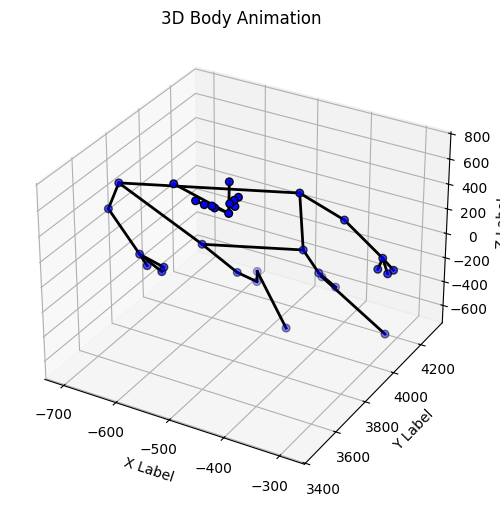

In [5]:
MT_tracking = pd.read_csv(MT_3D_input)

# Create a figure and axis
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Define the number of frames
num_frames = len(MT_tracking)

# Define the scatter plot
scatter = ax.scatter([], [], [], marker='o')


# Get the FPS and frame count of your 2D video to ensure that the 3D animation has the same duration
cap = cv2.VideoCapture(videos_input_2D[0])  # here only using the first one because all videos have the same duration
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count_2D = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration_2D = frame_count_2D / fps
cap.release()

# Ensure your 3D data matches the duration of the 2D videos
num_frames = int(duration_2D * fps)
MT_tracking = MT_tracking.iloc[:num_frames]


# Defyining Connectsion between landmarks to draw lines fro Example . #Change according to the landmarks in your data
connections = [
    # Head and torso
    ('nose', 'left_eye_inner'), 
    ('nose', 'right_eye_inner'),
    ('left_eye_inner', 'left_eye'), 
    ('left_eye', 'left_eye_outer'),
    ('right_eye_inner', 'right_eye'), 
    ('right_eye', 'right_eye_outer'),
    ('nose', 'left_ear'),
    ('nose', 'right_ear'),
    
    # Upper body (shoulders, arms)
    ('left_shoulder', 'right_shoulder'),
    ('left_shoulder', 'left_elbow'),
    ('left_elbow', 'left_wrist'),
    ('right_shoulder', 'right_elbow'),
    ('right_elbow', 'right_wrist'),
    
    # Lower body (hips, legs)
    ('left_shoulder', 'left_hip'),
    ('right_shoulder', 'right_hip'),
    ('left_hip', 'right_hip'),
    ('left_hip', 'left_knee'),
    ('left_knee', 'left_ankle'),
    ('right_hip', 'right_knee'),
    ('right_knee', 'right_ankle'),
    
    # Feet (toes and heel)
    ('left_ankle', 'left_heel'),
    ('right_ankle', 'right_heel'),
    ('left_heel', 'left_foot_index'),
    ('right_heel', 'right_foot_index'),
    
    # Optional: Left and right wrists to fingers (if available)
    ('left_wrist', 'left_pinky'),
    ('left_wrist', 'left_index'),
    ('left_wrist', 'left_thumb'),
    ('right_wrist', 'right_pinky'),
    ('right_wrist', 'right_index'),
    ('right_wrist', 'right_thumb')
]


# Calculate dynamic axis limits based on actual data ranges
x_min, x_max = MT_tracking.filter(like='_x').min().min(), MT_tracking.filter(like='_x').max().max()
y_min, y_max = MT_tracking.filter(like='_y').min().min(), MT_tracking.filter(like='_y').max().max()
z_min, z_max = MT_tracking.filter(like='_z').min().min(), MT_tracking.filter(like='_z').max().max()


# Enhanced Update function for animation
def update(frame):
    ax.clear()
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title('3D Body Animation')
    
    # Set the limits dynamically
    ax.set_xlim3d(x_min, x_max)
    ax.set_ylim3d(y_min, y_max)
    ax.set_zlim3d(z_min, z_max)

    # Extract the X, Y, and Z coordinates for the current frame
    frame_data = MT_tracking.iloc[frame]
    x = frame_data.filter(like='_x')
    y = frame_data.filter(like='_y')
    z = frame_data.filter(like='_z')

    # Plot the dots (landmarks)
    scatter = ax.scatter(x, y, z, marker='o', color='blue', s=30, edgecolor='k')  # s=30 for larger dots
    
    # Draw lines to connect the landmarks
    for part1, part2 in connections:
        # Get the coordinates for each pair of landmarks to connect
        x_line = [frame_data[part1 + '_x'], frame_data[part2 + '_x']]
        y_line = [frame_data[part1 + '_y'], frame_data[part2 + '_y']]
        z_line = [frame_data[part1 + '_z'], frame_data[part2 + '_z']]
        ax.plot(x_line, y_line, z_line, color='black', linewidth=2)  # Black lines with thickness 2

    return scatter,

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, interval=1000 / fps)

# Save the animation
output_folder = os.path.abspath('./animation_videos_temp_3')
output_file = os.path.join(output_folder, '3d_animation.mp4')
os.makedirs(output_folder, exist_ok=True)
ani.save(output_file, writer='ffmpeg', fps=fps)
print('Saved the enhanced 3D animation!')


#This will be our 3D input vido for the multimodal animation
animation_input_3D = output_file

## 4. Extract Amplitude Envelope and Plot Audio Signal 

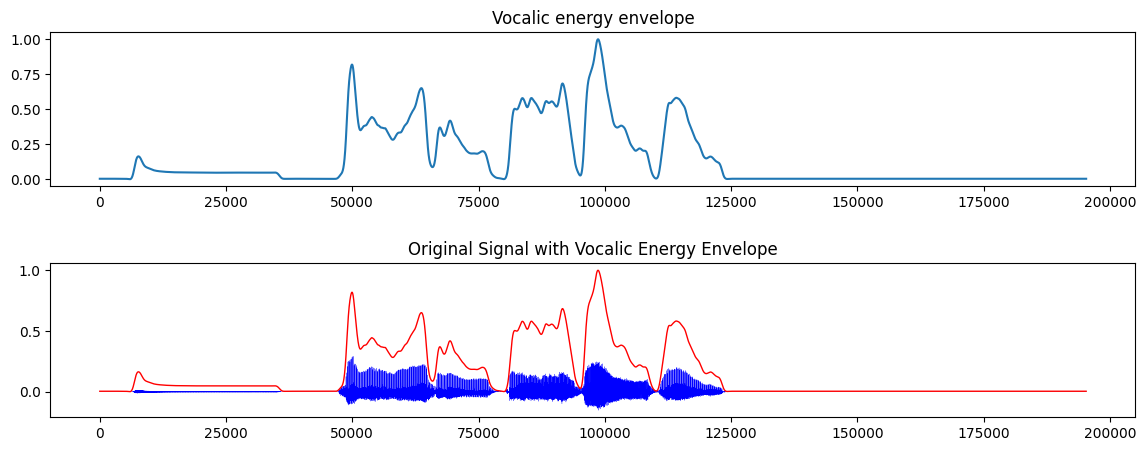

,time,audio,envelope
0,0.000000,-0.000031,0.003748
1,0.000063,-0.000031,0.003749
2,0.000125,-0.000031,0.003749
3,0.000188,-0.000031,0.003749
4,0.000250,-0.000031,0.003749


In [7]:
# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define the lowpass filter
def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to extract amplitude envelope
def amp_envelope(audiofilename):
    # load audio with librosa
    audio, sr = librosa.load(audiofilename, sr=None)
    # Bandpass filter 400-4000Hz
    data = butter_bandpass_filtfilt(audio, 400, 4000, sr, order=2)
    # Lowpass filter 10Hz
    data = butter_lowpass_filtfilt(np.abs(data), 10, sr, order=2)
    # scale from 0 to 1
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr

# Get the amplitude envelope
ampv, sr = amp_envelope(audio_input)
# Plot the filtered signal and the original signal
plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(ampv)
plt.title('Vocalic energy envelope')

# Extract and plot the original signal with the amplitude envelope
rawaudio, sr = librosa.load(audio_input, sr=None)
plt.subplot(2, 1, 2)
plt.plot(rawaudio, label = 'Original Signal', color='blue', linewidth=0.2)
plt.plot(ampv, label='Amplitude Envelope', color='red', linewidth=1)
plt.title('Original Signal with Vocalic Energy Envelope')

plt.subplots_adjust(hspace=0.5)  # Increase the space between subplots to move title down
plt.show()


# Create a Audio DataFrame with time (in secs, starting from 0) raw audio and amplitude envelope for later use
audio_df = pd.DataFrame({'time': np.arange(len(ampv)) / sr, 'audio': rawaudio, 'envelope': ampv})
audio_df.head()


## 5. Filter and Plot Physiological Signal: EMG, ECG and RESP

      LSL_Time  PLUX_P1_nSeq  PLUX_P1_ECG0  PLUX_P1_EMG1  PLUX_P1_EMG2  \
0  6700.956065     1383405.0       0.04393       0.00477      -0.00291   
1  6700.957064     1383406.0       0.04236       0.00118      -0.00259   
2  6700.958064     1383407.0       0.04142       0.00095       0.00195   
3  6700.959064     1383408.0       0.03994       0.00009       0.00254   
4  6700.960064     1383409.0       0.03306       0.00722       0.00023   

   PLUX_P1_RESPIRATION3  
0               0.28427  
1               0.28230  
2               0.28038  
3               0.28725  
4               0.29068  
Index(['LSL_Time', 'PLUX_P1_nSeq', 'PLUX_P1_ECG0', 'PLUX_P1_EMG1',
       'PLUX_P1_EMG2', 'PLUX_P1_RESPIRATION3'],
      dtype='object')


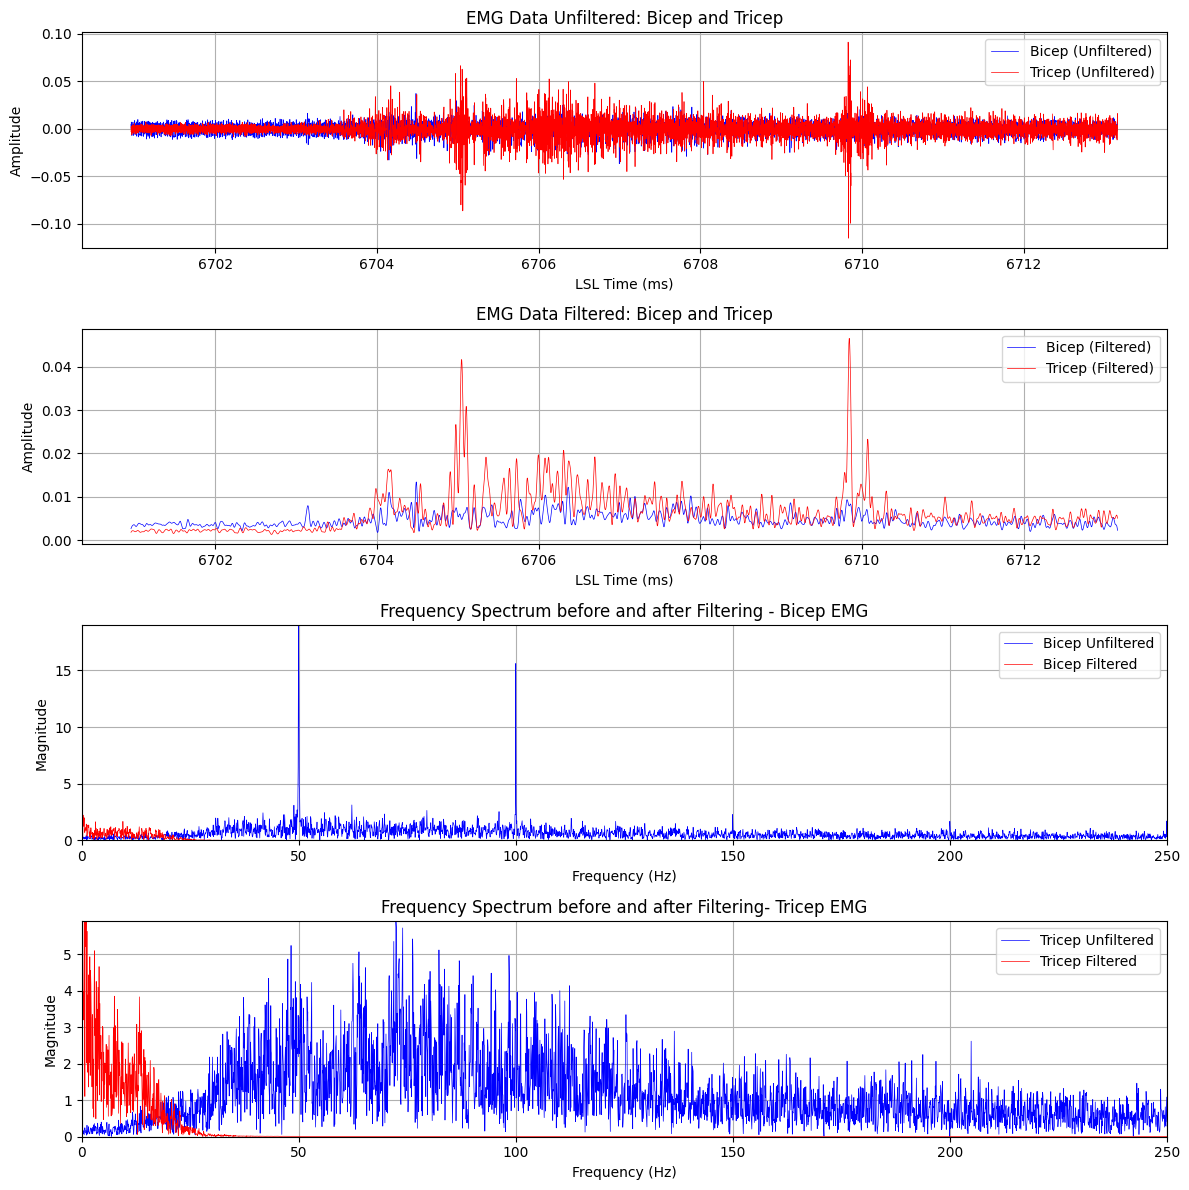

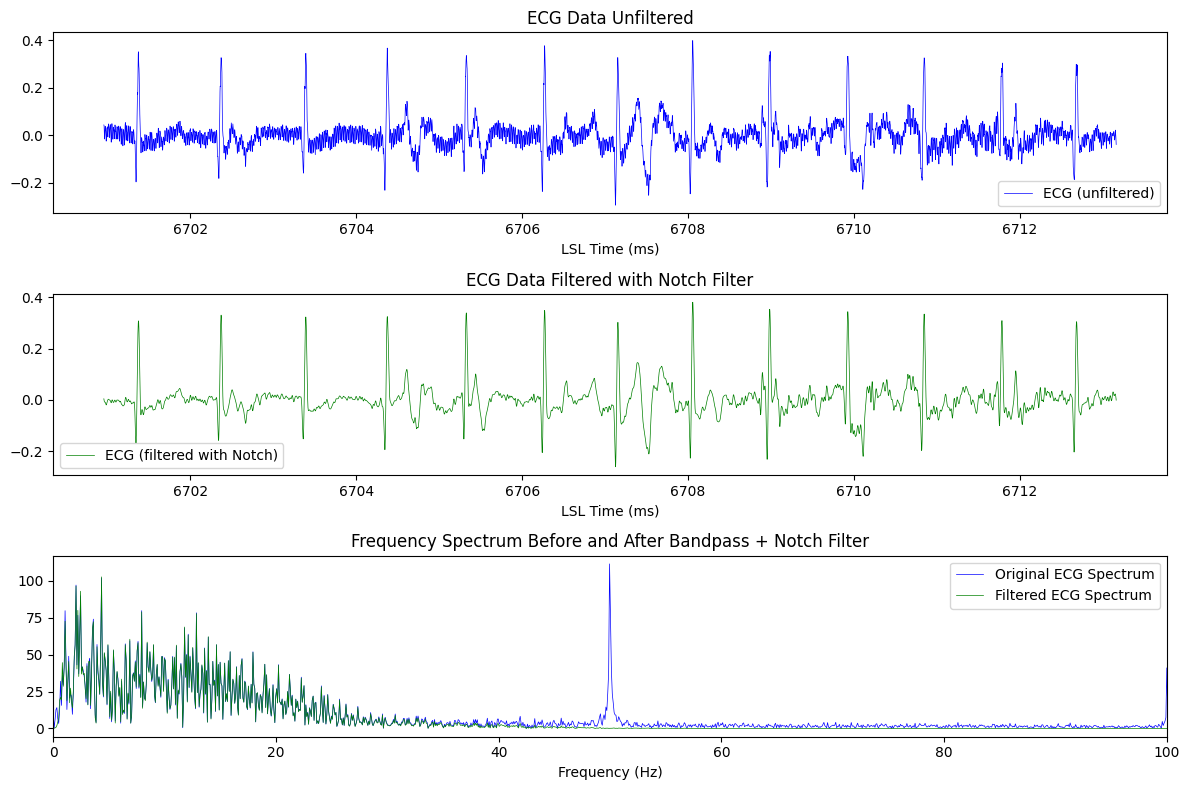

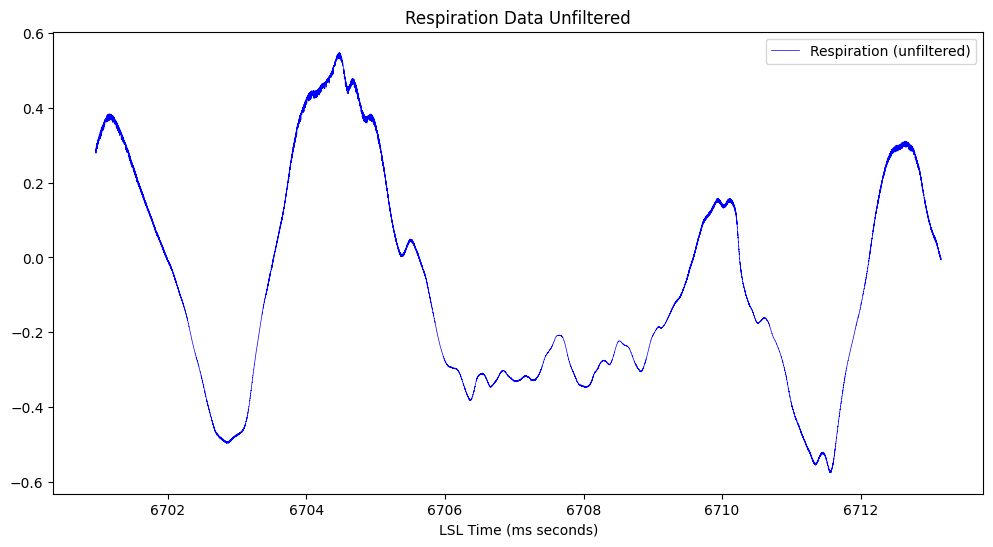

    time     resp
0  0.000  0.28427
1  0.001  0.28230
2  0.002  0.28038
3  0.003  0.28725
4  0.004  0.29068


In [8]:
PLUX_data = pd.read_csv(PLUX_input)
print(PLUX_data.head())  # To see the first few rows of the DataFrame
print(PLUX_data.columns)  # To list the column names

sampling_rate = 1000 # Sampling rate of 1000 Hz for our PLUX stream 

## ----------------  1. EMG DATA PROCESSING ---------------- ## 

# Define Butterworth filter function
def butter_filter(data, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    # Apply zero-phase filtering with padding to prevent edge effects
    padded_data = np.pad(data, (1000, 1000), 'edge')
    filtered_data = filtfilt(b, a, padded_data)
    return filtered_data[1000:-1000]  # Remove padding

# High-pass filter, rectify, and then low-pass filter EMG signals
def process_emg(emg_signal, fs, cutoff_high, cutoff_low):
    # Apply high-pass filter
    high_passed = butter_filter(emg_signal, cutoff_high, fs, order=4, filter_type='high')
    # Rectify (full-wave rectification)
    rectified = np.abs(high_passed)
    # Apply low-pass filter
    low_passed = butter_filter(rectified, cutoff_low, fs, order=4, filter_type='low')
    return low_passed

# Your EMG data and sampling rate
EMG_bicep = PLUX_data.iloc[:, 3].values
EMG_tricep = PLUX_data.iloc[:, 4].values
sampling_rate = 1000  # Replace with your actual sampling rate

# Process the EMG data for each muscle
EMG_bicep_processed = process_emg(EMG_bicep, sampling_rate, 2, 20)     # 2 Hz high-pass, 20 Hz low-pass
EMG_tricep_processed = process_emg(EMG_tricep, sampling_rate, 2, 20)   # 2 Hz high-pass, 20 Hz low-pass

# Compute frequency spectra for EMG bicep
freqs_bicep = np.fft.rfftfreq(len(EMG_bicep), d=1/sampling_rate)
fft_bicep = np.abs(np.fft.rfft(EMG_bicep))
fft_bicep_processed = np.abs(np.fft.rfft(EMG_bicep_processed))

# Compute frequency spectra for EMG tricep
freqs_tricep = np.fft.rfftfreq(len(EMG_tricep), d=1/sampling_rate)
fft_tricep = np.abs(np.fft.rfft(EMG_tricep))
fft_tricep_processed = np.abs(np.fft.rfft(EMG_tricep_processed))

# Visualization: Create a figure with 4 subplots
plt.figure(figsize=(12, 12))

# Subplot 1: Time-domain EMG data before filtering
plt.subplot(4, 1, 1)
plt.plot(PLUX_data['LSL_Time'], EMG_bicep, label='Bicep (Unfiltered)', color='blue', linewidth=0.5)
plt.plot(PLUX_data['LSL_Time'], EMG_tricep, label='Tricep (Unfiltered)', color='red', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.ylabel('Amplitude')
plt.title('EMG Data Unfiltered: Bicep and Tricep')
plt.grid(True)

# Subplot 2: Time-domain EMG data after filtering
plt.subplot(4, 1, 2)
plt.plot(PLUX_data['LSL_Time'], EMG_bicep_processed, label='Bicep (Filtered)', color='blue', linewidth=0.5)
plt.plot(PLUX_data['LSL_Time'], EMG_tricep_processed, label='Tricep (Filtered)', color='red', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.ylabel('Amplitude')
plt.title('EMG Data Filtered: Bicep and Tricep')
plt.grid(True)

# Subplot 3: Frequency spectrum for Bicep EMG
plt.subplot(4, 1, 3)
plt.plot(freqs_bicep, fft_bicep, label='Bicep Unfiltered', color='blue', linewidth=0.5)
plt.plot(freqs_bicep, fft_bicep_processed, label='Bicep Filtered', color='red', linewidth=0.5)
plt.xlim(0, 250)  # Adjust frequency range as needed
plt.ylim(0, max(fft_bicep))  # Adjust y-axis limits as needed
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum before and after Filtering - Bicep EMG')
plt.grid(True)

# Subplot 4: Frequency spectrum for Tricep EMG
plt.subplot(4, 1, 4)
plt.plot(freqs_tricep, fft_tricep, label='Tricep Unfiltered', color='blue', linewidth=0.5)
plt.plot(freqs_tricep, fft_tricep_processed, label='Tricep Filtered', color='red', linewidth=0.5)
plt.xlim(0, 250)
plt.ylim(0, max(fft_tricep))  # Adjust y-axis limits as needed
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum before and after Filtering- Tricep EMG')
plt.grid(True)

plt.tight_layout()
plt.show()

# Create a new ECG DataFrame with time (in secs) and the processed EMG signal for Bicep and Tricep
EMG_df = pd.DataFrame({'time': np.arange(len(EMG_bicep)) / sampling_rate, 'emg_bicep': EMG_bicep_processed, 'emg_tricep': EMG_tricep_processed})



## ----------------  2. ECG DATA PROCESSING ---------------- ##

# Define the notch filter function to remove powerline interference
def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    b, a = iirnotch(notch_freq / (fs / 2), quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Updated ECG processing function with notch filter
def process_ecg(ecg_signal, fs, cutoff_high, cutoff_low, notch_freq, quality_factor):
    # Apply high-pass filter
    high_passed = butter_filter(ecg_signal, cutoff_high, fs, order=4, filter_type='high')
    # Apply low-pass filter
    low_passed = butter_filter(high_passed, cutoff_low, fs, order=4, filter_type='low')
    # Apply notch filter
    filtered = notch_filter(low_passed, fs, notch_freq, quality_factor)
    return filtered

# Your ECG data and sampling rate
ECG = PLUX_data.iloc[:,2]

# Process the ECG signal with the notch filter
ECG_processed = process_ecg(ECG, sampling_rate, 0.5, 40, 50, 30)  # 0.5 Hz high-pass, 40 Hz low-pass, 50 Hz notch, 30 Q-factor


# Visualtiation with matplotlib: ECG data before and after filtering + Furier Transform frequency (3 subplots)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(PLUX_data['LSL_Time'], ECG, label='ECG (unfiltered)', color='blue', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.title('ECG Data Unfiltered')

plt.subplot(3, 1, 2)
plt.plot(PLUX_data['LSL_Time'], ECG_processed, label='ECG (filtered with Notch)', color='green', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms)')
plt.title('ECG Data Filtered with Notch Filter')

# Optional: Plot frequency spectrum to visualize the effect of the notch filter
freqs = np.fft.rfftfreq(len(ECG), d=1/sampling_rate)
fft_ecg = np.abs(np.fft.rfft(ECG))
fft_ecg_processed = np.abs(np.fft.rfft(ECG_processed))

plt.subplot(3, 1, 3)
plt.plot(freqs, fft_ecg, label='Original ECG Spectrum', color='blue', linewidth=0.5)
plt.plot(freqs, fft_ecg_processed, label='Filtered ECG Spectrum', color='green', linewidth=0.5)
plt.xlim(0, 100)  # Focus on frequencies up to 100 Hz
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Spectrum Before and After Bandpass + Notch Filter')

plt.tight_layout()
plt.show()


## Create a new ECG DataFrame with time (in secs) and the processed ECG signal
ECG_df = pd.DataFrame({'time': np.arange(len(ECG_processed))/ sampling_rate, 'ecg': ECG_processed})


## ----------------  3. RESPIRATION DATA PROCESSING ---------------- ##

RSP = PLUX_data.iloc[:,5]


# visualtiation with matplotlib: Unfiltered respiration data
plt.figure(figsize=(12, 6))
plt.plot(PLUX_data['LSL_Time'], RSP, label='Respiration (unfiltered)', color='blue', linewidth=0.5)
plt.legend()
plt.xlabel('LSL Time (ms seconds)')
plt.title('Respiration Data Unfiltered')
plt.show()

# Create a new Respiration DataFrame with time (in secs) and the raw respiration signal
RESP_df = pd.DataFrame({'time': np.arange(len(RSP)) / sampling_rate, 'resp': RSP})
print(RESP_df.head())



## 5. Create the Multimodal Animation 

In [13]:
# what is the window size in seconds
window = 4


def plot_multimodal(audio, emg, ecg, resp, midpoint, window=4):
    # Temporary folder for saving the plot
    tempfolder = tempfile.mkdtemp()

    # Create 4 subplots for the different data streams
    fig, ax = plt.subplots(4, 1, figsize=(14, 16))  # 4 rows (Audio, EMG, ECG, RESP)

    # Define the time window for all plots
    start = -window / 2
    end = window / 2

    # Create local time variables adjusted for the current midpoint
    audio_time = audio['time'] - midpoint
    emg_time = emg['time'] - midpoint
    ecg_time = ecg['time'] - midpoint
    resp_time = resp['time'] - midpoint

    # Filter the data to the time window
    audio_mask = (audio_time >= start) & (audio_time <= end)
    emg_mask = (emg_time >= start) & (emg_time <= end)
    ecg_mask = (ecg_time >= start) & (ecg_time <= end)
    resp_mask = (resp_time >= start) & (resp_time <= end)

    # Plot 1: Audio envelope
    ax[0].plot(audio_time.loc[audio_mask], audio['audio'].loc[audio_mask], label='Raw Audio', linewidth=0.5)
    ax[0].plot(audio_time.loc[audio_mask], audio['envelope'].loc[audio_mask], label='Envelope', linewidth=1.5)
    ax[0].set_xlim(start, end)
    ax[0].set_ylim(min(audio['audio']), max(audio['envelope']))  # Adjust as needed based on your signal
    ax[0].legend(prop={'size': 18})
    ax[0].set_ylabel('Amplitude')

    # Plot 2: Filtered EMG signal
    ax[1].plot(emg_time.loc[emg_mask], emg['emg_bicep'].loc[emg_mask], label='EMG Bicep', color='green', linewidth=1)
    ax[1].plot(emg_time.loc[emg_mask], emg['emg_tricep'].loc[emg_mask], label='EMG Tricep', color='red', linewidth=1)
    ax[1].set_xlim(start, end)
    ax[1].set_ylim(min(min(emg['emg_bicep']), min(emg['emg_tricep'])), max(max(emg['emg_bicep']), max(emg['emg_tricep'])))
    ax[1].legend(prop={'size': 18})
    ax[1].set_ylabel('Amplitude')

    # Plot 3: Filtered ECG signal
    ax[2].plot(ecg_time.loc[ecg_mask], ecg['ecg'].loc[ecg_mask], label='ECG Signal', color='blue', linewidth=1)
    ax[2].set_xlim(start, end)
    ax[2].set_ylim(min(ecg['ecg']), max(ecg['ecg']))  # Adjust as needed based on your signal
    ax[2].legend(prop={'size': 18})
    ax[2].set_ylabel('Amplitude')

    # Plot 4: Respiratory signal
    ax[3].plot(resp_time.loc[resp_mask], resp['resp'].loc[resp_mask], label='Respiration', color='orange', linewidth=1)
    ax[3].set_xlim(start, end)
    ax[3].set_ylim(min(resp['resp']), max(resp['resp']))  # Adjust as needed based on your signal
    ax[3].legend(prop={'size': 18})
    ax[3].set_ylabel('Respiration')
    ax[3].set_xlabel('Time (s)')


    #Apply a vertical line at time 0 for all subplots
    ax[0].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)
    ax[1].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)
    ax[2].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)
    ax[3].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)

    # Apply tight layout and save plot
    plt.tight_layout()
    tpf = tempfolder + '/tempfig.png'
    plt.savefig(tpf)
    plt.close()

    # Load and return the image as a frame for the video
    img = cv2.imread(tpf)
    shutil.rmtree(tempfolder)
    #show image in the terminal
    return img


def process_video_with_multimodal(videos_2D, animation_3D, audio, emg, ecg, resp, output_filename):
    # Open the three 2D videos
    captures_2D = [cv2.VideoCapture(vf) for vf in videos_2D]
    
    # Open the 3D animation video
    capture_3D = cv2.VideoCapture(animation_3D)
    
    # Check if all videos opened successfully
    if not all([cap.isOpened() for cap in captures_2D]) or not capture_3D.isOpened():
        print("Error opening one or more video files.")
        return
    
    # Get video properties of 2D videos (assuming all videos have the same properties)
    fps = captures_2D[0].get(cv2.CAP_PROP_FPS)
    frame_count = int(captures_2D[0].get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(captures_2D[0].get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captures_2D[0].get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Get properties of the 3D animation video
    frame_width_3D = int(capture_3D.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height_3D = int(capture_3D.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps_3D = capture_3D.get(cv2.CAP_PROP_FPS)
    frame_count_3D = int(capture_3D.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Ensure synchronization (assuming same fps and frame count)
    if fps != fps_3D or frame_count != frame_count_3D:
        print("Mismatch in FPS or frame count between videos.")
        return
    
    # Calculate dimensions for the video grid
    # Top: 3 videos (side by side)
    video_top_width = frame_width * 3
    # video_top_height = frame_height - (frame_height // 3) # Reduce height by 1/3
    video_top_height = frame_height  # Keep the same height

    # Set the desired width of the 3D animation (e.g., half of video_top_width)
    animation_width = int(video_top_width)  # Half the width of the top videos
    # Maintain aspect ratio
    scale_factor = animation_width / frame_width_3D
    animation_height = int(frame_height_3D * scale_factor)
    
    # Video combined height
    video_height = video_top_height + animation_height  # Top videos + 3D animation

    # Create a sample plot to determine plot height
    tempfolder = tempfile.mkdtemp()
    fig, ax = plt.subplots(4, 1, figsize=(14, 16))
    plt.tight_layout()
    tpf = tempfolder + '/tempfig.png'
    plt.savefig(tpf)
    plt.close()
    plot_img = cv2.imread(tpf)
    plot_height, plot_width, _ = plot_img.shape
    shutil.rmtree(tempfolder)
    
    # Total output frame dimensions
    total_width = video_top_width
    total_height = video_height + plot_height

    print(f"Total video dimensions: {total_width}x{total_height}")
    
    # Set up video writer for the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (total_width, total_height))

    if not out.isOpened():
        print("Error: VideoWriter not initialized correctly.")
        return
    
    frame_number = 0
    for i in tqdm.tqdm(range(frame_count)):
        # Read frames from the three 2D videos
        frames_2D = []
        for cap in captures_2D:
            ret, frame = cap.read()
            if not ret:
                break
            frames_2D.append(frame)
        if len(frames_2D) != len(captures_2D):
            break  # Not enough frames
        
        # Read frame from the 3D animation video
        ret_3D, frame_3D = capture_3D.read()
        if not ret_3D:
            break
        
        # Resize 2D frames if needed
        resized_frames_2D = [cv2.resize(f, (frame_width, frame_height)) for f in frames_2D]
        
        # Arrange the 3 2D videos side by side (top)
        video_top = np.hstack(resized_frames_2D)
        
        # Resize the 3D animation frame
        frame_3D_resized = cv2.resize(frame_3D, (animation_width, animation_height))
        
        # Create a blank image for the bottom part (same width as video_top)
        bottom_image = np.zeros((animation_height, video_top_width, 3), dtype=np.uint8)
        
        # Center the 3D animation in the bottom_image
        x_offset = (video_top_width - animation_width) // 2
        y_offset = 0  # Top of bottom_image
        bottom_image[y_offset:y_offset+animation_height, x_offset:x_offset+animation_width] = frame_3D_resized
        
        # Combine top and bottom images vertically
        video_combined = np.vstack((video_top, bottom_image))
        
        # Generate the multimodal plot for the current window
        midpoint = frame_number / fps
        multimodal_img = plot_multimodal(audio, emg, ecg, resp, midpoint)
        
        # Resize the plot to match the width of the video_combined
        multimodal_img = cv2.resize(multimodal_img, (total_width, plot_height))
        
        # Combine the video_combined and the plot vertically
        combined_frame = np.vstack((video_combined, multimodal_img))
        
        # Write the combined frame to the output video
        out.write(combined_frame.astype(np.uint8))
        
        frame_number += 1

        ##show the frame (otpional)
        #cv2.imshow('Frame', combined_frame)
    
    # Release video objects
    for cap in captures_2D:
        cap.release()
    capture_3D.release()
    out.release()
    cv2.destroyAllWindows()


animation_input_3D = output_file


output_folder = os.path.abspath('./animation_videos_temp_x')
output_filename = os.path.join(output_folder, 'multimodal_video_5.mp4')

#make sure the folder exists
os.makedirs(output_folder, exist_ok=True)


process_video_with_multimodal(videos_input_2D, animation_input_3D, audio_df, EMG_df, ECG_df, RESP_df, output_filename)





Total video dimensions: 1620x3532


100%|██████████| 681/681 [07:31<00:00,  1.51it/s]


In [31]:
print('audio start')
print(audio_df.head())
print('audio end')
print(audio_df.tail())

print('emg start')
print(EMG_df.head())
print('emg end')
print(EMG_df.tail())

print('ecg start')
print(ECG_df.head())
print('ecg end')
print(ECG_df.tail())

print('resp start')
print(RESP_df.head())
print('resp end')
print(RESP_df.tail())

# Open one of your videos
cap = cv2.VideoCapture(videos_input_2D[0])
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_duration = frame_count / fps
cap.release()

print(f"Video Duration: {video_duration} seconds")



audio start
       time     audio  envelope
0  0.000000 -0.000031  0.002007
1  0.000063 -0.000031  0.002008
2  0.000125 -0.000031  0.002008
3  0.000188 -0.000031  0.002008
4  0.000250 -0.000031  0.002009
audio end
             time     audio  envelope
195400  12.212500  0.000153  0.002122
195401  12.212563  0.000153  0.002122
195402  12.212625  0.000153  0.002122
195403  12.212687  0.000122  0.002122
195404  12.212750  0.000122  0.002122
emg start
    time  emg_bicep  emg_tricep
0  0.000   0.004012    0.004489
1  0.001   0.004397    0.005017
2  0.002   0.004785    0.005577
3  0.003   0.005170    0.006165
4  0.004   0.005551    0.006778
emg end
         time  emg_bicep  emg_tricep
12210  12.210   0.003504    0.005443
12211  12.211   0.003353    0.005263
12212  12.212   0.003198    0.005067
12213  12.213   0.003040    0.004857
12214  12.214   0.002881    0.004635
ecg start
    time       ecg
0  0.000 -0.037212
1  0.001 -0.036089
2  0.002 -0.034548
3  0.003 -0.032619
4  0.004 -0.030350
ec

In [36]:
(min(audio_df['audio']), max(audio_df['envelope']))

(-0.1820068359375, 1.0)

In [38]:
# Get video properties of 2D videos (assuming all videos have the same properties)
captures_2D = [cv2.VideoCapture(vf) for vf in videos_input_2D]
fps = captures_2D[0].get(cv2.CAP_PROP_FPS)
frame_count = int(captures_2D[0].get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(captures_2D[0].get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(captures_2D[0].get(cv2.CAP_PROP_FRAME_HEIGHT))

print(frame_height)

960
